We have found a fair amount of problems with trying to add noise to V4 to make the comparison fair between V4 and the CNN. Namely we have found problems in deciding on how to form a neural like pdf around arbitrary CNN units responses. 
Instead we can work with neural data where we don't have to arbitrrily guess as much at the appropriate distribution. We know a couple good approximations to the distribution (Poisson, Negative Binomial) and we can use this info to estimate what the correlation of V4 would have been in expectation to our model.

We can imagine that the true distribution of our V4 response is centered around the mean vector. The model vector has some angle with the V4 response vector. When we take samples from the V4 response distribution our expected correlation is found by integrating along the cones surrounding the model vector describing equal correlation values. 

<img src="correlation/1.png" style="max-width:50%; width: 30%">

If we think about the cone passing through the true V4 mean and we assume the V4 response distribution is roughly symmetric then there is more mass outside the cone then inside the cone, thus while our correlation value is consistent, it is also biased with increasing bias for fewer samples. Unfortunately I don't know how to integrate over these cones, to get the expected value of the bias for a given number of samples. So instead I will estimate with simulation.

We will assume:

* The absolute direction of the model vector is not important, only its correlation with the expected response vector is.

* Our estimation of the response distribution doesn't greatly influence estimated drop in correlation.

So we will uniformly sample on the cone of **models** around the response distribution to get an estimate of for that correlation how much our correlation would go down from the true correlation. Our response distribution is assumed to be Poisson and for each cell we can then just take the expected value of each response for our estimate.

<img src="correlation/2.png" style="max-width:50%; width: 30%">

How will we do this? We will generate synthetic models from spherical gaussian noise, then rotate them to the correct correlation with our mean response.

<img src="correlation/3.png" style="max-width:50%; width: 30%">

<img src="correlation/4.png" style="max-width:50%; width: 30%">


We will do this many times for each synthetic vector and for many different synthetic vectors so we can have some measure of the variability of using many different models. We will then do this for many different true correlations, and see how the correlation after noise changes as a function of true correlation.

This is not exactly a simulation of the fitting procedure to the APC model, we are assuming there is only one model vector whereas in the APC model there are thousands of very correlated models. We can discuss this difference after looking at the results for this simple case. We can think of this simple case with respect to one model vector as the test score in a validation.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as  l
import os, sys
top_dir = os.getcwd().split('ipython_nb')[0]
sys.path.append(top_dir + 'xarray')
top_dir = top_dir+ 'v4cnn/'
sys.path.append(top_dir)
sys.path.append(top_dir + 'common')
import xarray as xr
import pandas as pd
%matplotlib inline

v4_resp_mean = xr.open_dataset(top_dir + 'data/responses/V4_362PC2001.nc')['resp'].load()
v4_resp_trials = xr.open_dataset(top_dir + 'data/responses/apc_orig/apc370_with_trials.nc')
v4_resp_trials = v4_resp_trials['resp'].load().transpose('shapes','unit','trials')
v4_resp_trials = v4_resp_trials.loc[v4_resp_mean.coords['shapes'].values, :, :]
v4_resp_mean = v4_resp_trials.mean('trials')

cnn_names =['bvlc_reference_caffenetAPC362_pix_width[32.0]_pos_(64.0, 164.0, 51)',]
da = xr.open_dataset(top_dir + 'data/responses/' + cnn_names[0] + '.nc')['resp']
da = da.sel(unit=slice(0, None, 1)).squeeze()
middle = np.round(len(da.coords['x'])/2.).astype(int)
da_0 = da.sel(x=da.coords['x'][middle])
da_0 = da_0.loc[v4_resp_mean.coords['shapes'].values, 96:96*2]

In [3]:
def adjust_to_r(static_vector, shift_vector, desired_r):
    #center both vectors
    if np.corrcoef(shift_vector, static_vector)[0,1]<0:
        shift_vector = -shift_vector
    b = shift_vector
    b = b - b.mean()
    x = static_vector
    x = x - x.mean()
    
    #project x onto b
    s = np.dot(x, b)/np.linalg.norm(b)**2
    b = b * s
    #get the error vector, or vecto pointing from tip of b to x
    e = x - b
    #convert desired r to angle    
    theta = np.arccos(desired_r)
    #get current angle between x and b
    phi = np.arccos(np.corrcoef(x, b)[0,1])
    #how much angle to shift b
    beta = phi - theta
    mag_b = np.linalg.norm(b)#adjacent length
    mag_e = np.linalg.norm(e)#opposite length
    #solve for scaling of a to the opposite side for beta
    a = (mag_b * np.tan(beta))/mag_e
    shifted_vector = a * e + b # now shift b with a*e
    return shifted_vector

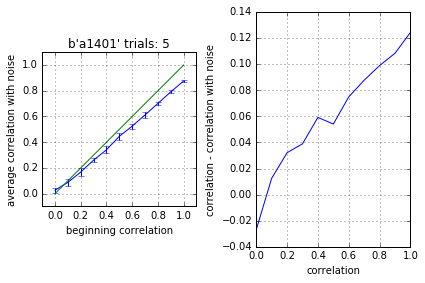

In [4]:
x = v4_resp_mean[:,1]
nstim = x.shape[0]
correlations = np.linspace(0, 1, 11)
n_model_resample = 20
n_noise_resample = 20
n_trials = 5
r_list = []

for desired_r in correlations:
    gen_vec = np.random.randn(n_model_resample, nstim)
    for vec in gen_vec:
        shift_vec = adjust_to_r(x, vec, desired_r)
        sim_resp = np.random.poisson(x, size=(n_noise_resample, n_trials, nstim))
        r = [np.corrcoef(resp, shift_vec)[0, 1] for resp in sim_resp.mean(1)]
    r_list.append(r)

r_list = np.abs(np.array(r_list))
m_cor = r_list.mean(1).squeeze()

plt.subplot(121)
plt.errorbar(correlations, m_cor, yerr=np.std(r_list,1))
plt.xlabel('beginning correlation')
plt.ylabel('average correlation with noise')
plt.axis('square')
plt.xlim(-0.1,1.1);plt.ylim(-0.1,1.1);plt.plot([0,1],[0,1])
plt.grid();plt.title(str(x.coords['w_lab'].values) + ' trials: ' + str(n_trials) )
plt.subplot(122)
plt.plot(correlations, correlations-m_cor)
plt.xlabel('correlation');plt.ylabel('correlation - correlation with noise')
plt.grid();plt.tight_layout()

#why is it a line?
#all of my neural correlations should be less than the max of m_cor

Here is an example cell where we have performed the procedure above. We can see as expected that adding noise to a perfect correlation creates the biggest change in correlation. Interestingly the decrease in correlation, with different starting points of correlation seems to be well described as line. STD relative to the line seems to be quite small thus the angle of the model doesn't seem to make a big difference.
I've looked around at a couple different cells, and this line trend seems to hold up but the slope of the line tends to vary considerably across cells. Because the end of the line is zero, just by measured the drop in correlation from 1 is sufficient to know the values at other starting point 

$$R_{noise} = R_{r=1 \ noise}*R_{noise \ free}$$

$$R_{noise \ free} =  \frac{R_{noise}}{R_{r=1 \ noise}}$$

Lets look at the variability in the slope of this line ($R_{r=1 \ noise}$) across cells, and perhaps explain it as a function of the sparseness of response.

In [5]:
m_cor_list = []
for cell in range(v4_resp_mean.shape[1]):
    x = v4_resp_mean[:,cell]
    nstim = x.shape[0]
    correlations = [1,]
    n_model_resample = 20
    n_noise_resample = 20
    n_trials = 5
    r_list = []

    for desired_r in correlations:
        gen_vec = np.random.randn(n_model_resample, nstim)
        for vec in gen_vec:
            shift_vec = adjust_to_r(x, vec, desired_r)
            sim_resp = np.random.poisson(x, size=(n_noise_resample, n_trials, nstim))
            r = [np.corrcoef(resp, shift_vec)[0, 1] for resp in sim_resp.mean(1)]
        r_list.append(r)

    r_list = np.abs(np.array(r_list))
    m_cor_list.append(np.mean(r_list))

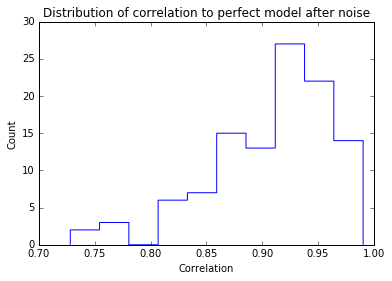

In [6]:
_=plt.hist(np.array(m_cor_list), histtype='step')
plt.title('Distribution of correlation to perfect model after noise')
plt.xlabel('Correlation');plt.ylabel('Count');


Looks like its typical to drop around 1/10 of a correlation at most, but their is a fair amount of variability. We suspected that the noise resistant cells would be those with high selectivity. Lets plot this measure against kurtosis.

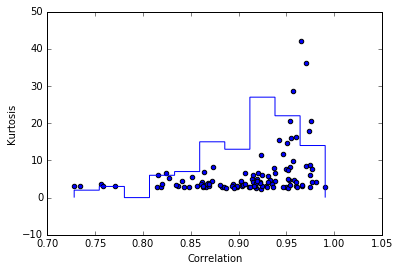

In [7]:
def kurtosis_unit(unit):
    mu = np.mean(unit)
    sig = np.std(unit)
    k = (np.sum(((unit - mu)**4)))/((sig**4)*len(unit))
    return k

k = [kurtosis_unit(cell) for cell in v4_resp_mean.T]
plt.scatter(m_cor_list, k)
#plt.semilogy()
plt.xlabel('Correlation');
plt.ylabel('Kurtosis');
_=plt.hist(m_cor_list, histtype='step')


There seems to be some relationship here, in that the highest kurtosis units tend to also have the highest noise cor slope. Still there are many exceptions where high noise cor slopes have some of the lowest kurtosis. I suspect we need to take into account measures of the absolute firing rates dispersion, lets try a couple.

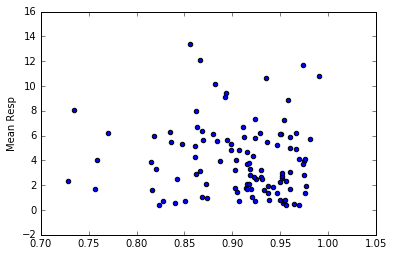

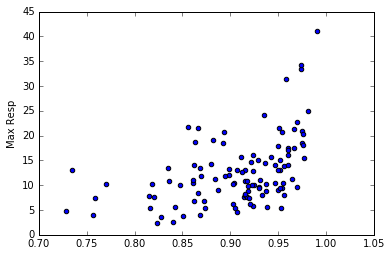

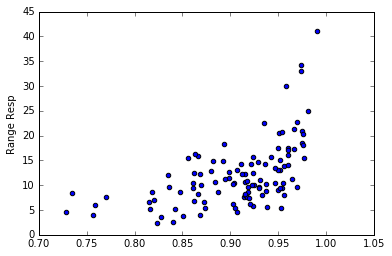

In [8]:
plt.scatter(m_cor_list, v4_resp_mean.mean('shapes'))
plt.ylabel('Mean Resp')
plt.figure()
plt.scatter(m_cor_list, v4_resp_mean.max('shapes'))
plt.ylabel('Max Resp')
plt.figure()
plt.scatter(m_cor_list, v4_resp_mean.max('shapes') - v4_resp_mean.min('shapes'))
plt.ylabel('Range Resp')


There seems to be more of a relationship between measures that take into account absolute range. Wyeth gave a reason for this but I forgot it.

One firm prediction that this type of modeling makes is that we should expect the correlation of a cell to a model not to exceed its slope in this analysis.

In [9]:
import apc_model_fit as ac
fn = top_dir + 'data/models/' + 'apc_models_362.nc'
if 'apc_fit_v4' not in locals():
    dmod = xr.open_dataset(fn, chunks={'models':50, 'shapes':370})['resp'].load()
    apc_fit_v4 = ac.cor_resp_to_model(v4_resp_mean.chunk({'shapes': 370}), 
                                      dmod.chunk({}), 
                                      fit_over_dims=None, 
                                      prov_commit=False)

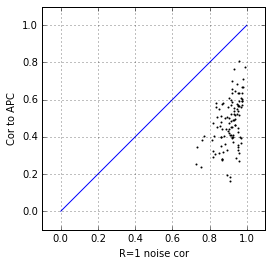

In [10]:
plt.scatter(m_cor_list, apc_fit_v4, s=1)
plt.ylabel('Cor to APC')
plt.xlabel('R=1 noise cor')
plt.axis('square')
plt.xlim(-0.1,1.1);plt.ylim(-0.1,1.1);plt.plot([0,1],[0,1])
plt.grid();
plt.figure()

Good. All correlation values are below their expected limit. This first off implies that the APC model is not perfect for any of these cells, even accounting for the effect of noise.
Finally lets see if correcting for noise creates a big difference in the distribution of correlations to the APC model for V4.

In [ ]:
_=plt.scatter(apc_fit_v4/m_cor_list, apc_fit_v4, s=1)
plt.axis('square')
plt.xlim(-0.1,1.1);plt.ylim(-0.1,1.1);plt.plot([0,1],[0,1])
plt.xlabel('Estimated R in Expectation')
plt.ylabel('Original R')
plt.title('R correction dividing by R=1 noise cor')
plt.grid()
plt.figure()
_ = plt.hist(apc_fit_v4/m_cor_list-apc_fit_v4, histtype='step')
plt.tight_layout()
plt.xlabel('Corrected R - Original R')
plt.ylabel('Count')
np.mean(apc_fit_v4/m_cor_list-apc_fit_v4)

<xarray.DataArray ()>
array(0.04645232627035514)

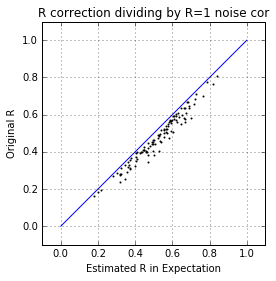

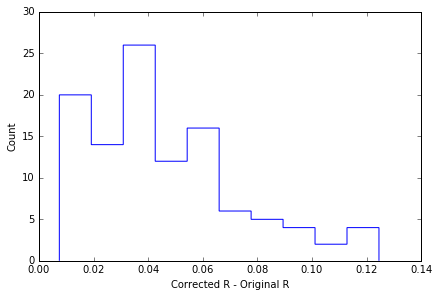

There is an effect, but it is subtle. 

<h2>Testing our estimation for predictivity</h2>

One more thing we might want to do is see if this model of noise is predictive by adding in more trials progressively from the original data and see if it predicts the increase in correlation better than the estimate given by the mean.

<img src="correlation/5.png" style="max-width:50%; width: 50%">


In [ ]:
corrected_r = apc_fit_v4/m_cor_list

m_cor_list = []
#for cell in range(v4_resp_mean.shape[1]-100):
cell = 0 
x = v4_resp_mean[:,cell]
nstim = x.shape[0]
correlations = [corrected_r[cell], apc_fit_v4[cell]] 
n_model_resample = 20
n_noise_resample = 20
n_trials = 5
r_list = []
np.zeros()
for i_trial, ntrials in enumerate(range(1, 5)):
    for i_cor, desired_r in enumerate(correlations):
        gen_vec = np.random.randn(n_model_resample, nstim)
        for i_resamp, vec in enumerate(gen_vec):
            shift_vec = adjust_to_r(x, vec, desired_r)
            sim_resp = np.random.poisson(x, size=(n_noise_resample, n_trials, nstim))
            r = [np.corrcoef(resp, shift_vec)[0, 1] for resp in sim_resp.mean(1)]
            
